# Covid-19 CT-Scan Classifier

Using Keras, the aim of this notebook is to build a CNN to  classify CT-scans of various patients into 2 categories: Covid and non-Covid.

The data can be found at https://www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset. It provides 2482 CT scan images, which is divided between 1252 for patients infected by SARS-CoV-2, and 1230 CT scans for non-infected by SARS-CoV-2 patients.

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sklearn
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import models
from keras import layers
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D

Define some functions for readability...

In [2]:
def read_img(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 

def resize_img(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

## Data

Creating dataframe.

In [3]:
disease_types=['COVID', 'non-COVID']
data_dir = 'C:/Users/jguze/input/sarscov2-ctscan-dataset'
train_dir = os.path.join(data_dir)

In [4]:
## Note enumerate(disease_types) contains (0, COVID), (1, non-COVID)

train_data = []
for enumeration, spelled in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, spelled)):
        train_data.append(['{}/{}'.format(spelled, file), enumeration, spelled])

In [5]:
## Transfer train_data to a pandas df

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head().append(train.tail())

,File,DiseaseID,Disease Type
0,COVID/Covid (1).png,0,COVID
1,COVID/Covid (10).png,0,COVID
2,COVID/Covid (100).png,0,COVID
3,COVID/Covid (1000).png,0,COVID
4,COVID/Covid (1001).png,0,COVID
2476,non-COVID/Non-Covid (995).png,1,non-COVID
2477,non-COVID/Non-Covid (996).png,1,non-COVID
2478,non-COVID/Non-Covid (997).png,1,non-COVID
2479,non-COVID/Non-Covid (998).png,1,non-COVID
2480,non-COVID/Non-Covid (999).png,1,non-COVID


The data is now well formatted and clearly labeled, it's ready to be worked with. 

## Constructing Training/Validation Sets

Resize each image to 64x64. Create a 64x64x3 matrix for each resized image to give RGB representations. Recall our definitions of read_img and resize_img earlier.

In [6]:
## Create a matrix of zeroes as described above

Size = 64
X = np.zeros((len(train), Size, Size, 3))

In [7]:
## The function read_img, as defined earlier, uses the OpenCV function cv2.imread to return the RBG representation of the image.
## After, we normalise X

for i, file in enumerate(train['File'].values):
    image = read_img(file)
    if image is not None:
        X[i] = resize_img(image, (Size, Size))
        
X /= 255       
y = train['DiseaseID'].values

## Convert integer class representation in y to binary vector representation. Note [1,0] is COVID representation

y = to_categorical(y, num_classes=2)

In [8]:
## Using scikit-learn, split the data into training and validation sets, 80/20 split. Stratify to ensure both sets have a
## proportionally similair number of COVID patients.

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 42)

Now X and y are prepared for training the CNN on. Check the data is as expected...

In [9]:
print(X[0,:,:,:],y[0])

[[[0.76470588 0.76470588 0.76470588]
  [0.76470588 0.76470588 0.76470588]
  [0.76862745 0.76862745 0.76862745]
  ...
  [0.76470588 0.76470588 0.76470588]
  [0.76862745 0.76862745 0.76862745]
  [0.76470588 0.76470588 0.76470588]]

 [[0.76078431 0.76078431 0.76078431]
  [0.76078431 0.76078431 0.76078431]
  [0.76078431 0.76078431 0.76078431]
  ...
  [0.76470588 0.76470588 0.76470588]
  [0.75686275 0.75686275 0.75686275]
  [0.76470588 0.76470588 0.76470588]]

 [[0.76078431 0.76078431 0.76078431]
  [0.76078431 0.76078431 0.76078431]
  [0.76470588 0.76470588 0.76470588]
  ...
  [0.75686275 0.75686275 0.75686275]
  [0.75294118 0.75294118 0.75294118]
  [0.76078431 0.76078431 0.76078431]]

 ...

 [[0.78431373 0.78431373 0.78431373]
  [0.78823529 0.78823529 0.78823529]
  [0.78823529 0.78823529 0.78823529]
  ...
  [0.87058824 0.87058824 0.87058824]
  [0.87058824 0.87058824 0.87058824]
  [0.87058824 0.87058824 0.87058824]]

 [[0.76862745 0.76862745 0.76862745]
  [0.77647059 0.77647059 0.77647059]


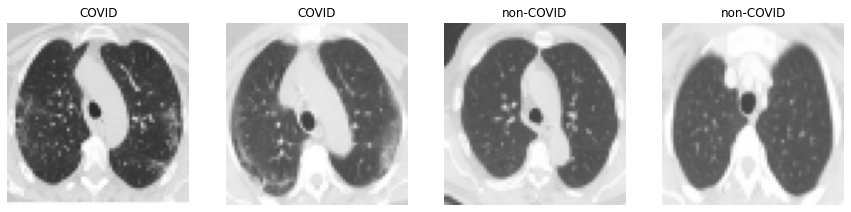

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
k=[0,700,1400,2100]
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(X[k[i]])
    if y[k[i]][0]==1:
        ax[i].set_title('COVID')
    else:
        ax[i].set_title('non-COVID')

## Developing the CNN

After experimenting with transfer leaning using ImageNet alongside ResNet and DenseNet architectures, the benefits don't seem substantial. This can likely be attributed to the CT-scans being considerably different to any picture in ImageNet, so the 'transferring' is minimal. Resultingly, I'll build a CNN from scratch.

In [68]:
Size = 64
EPOCHS = 45
BATCH_SIZE = 64

In [69]:
## Introduce data augmentation to combat overfitting

datagen = ImageDataGenerator(rotation_range=15, # Degree range for random rotations
                        width_shift_range=0.1, # Range for random horizontal shifts
                        height_shift_range=0.1, # Range for random vertical shifts
                        zoom_range=0.1, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        ) 

In [70]:
## Avoid sigmoid activation in training due to vanishing gradient. ReLu seems to give good results

model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(528, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [71]:
## Check structure of the CNN

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 12, 12, 256)       590080    
_________________________________________________________________
dropout_30 (Dropout)         (None, 12, 12, 256)     

In [74]:
## Use rmsprop as optimizer and reduce the learning rate in the case of stagnation

optimizer = RMSprop(learning_rate=0.001)
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.75, patience=4, verbose=1, min_lr=0.0001)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

In [75]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                              steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=[annealer, checkpoint],
                              validation_data=(X_val, y_val))

Epoch 1/45
31/31 [==============================] - 27s 883ms/step - loss: 0.8959 - accuracy: 0.6973 - val_loss: 0.3903 - val_accuracy: 0.8551

Epoch 00001: val_loss improved from inf to 0.39029, saving model to model.h5
Epoch 2/45
31/31 [==============================] - 27s 870ms/step - loss: 0.5297 - accuracy: 0.7601 - val_loss: 0.3717 - val_accuracy: 0.8390

Epoch 00002: val_loss improved from 0.39029 to 0.37166, saving model to model.h5
Epoch 3/45
31/31 [==============================] - 27s 865ms/step - loss: 0.4961 - accuracy: 0.7747 - val_loss: 0.7982 - val_accuracy: 0.6076

Epoch 00003: val_loss did not improve from 0.37166
Epoch 4/45
31/31 [==============================] - 27s 858ms/step - loss: 0.5462 - accuracy: 0.7553 - val_loss: 0.8064 - val_accuracy: 0.5453

Epoch 00004: val_loss did not improve from 0.37166
Epoch 5/45
31/31 [==============================] - 27s 866ms/step - loss: 0.5202 - accuracy: 0.7797 - val_loss: 0.5692 - val_accuracy: 0.6972

Epoch 00005: ReduceL


Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.00023730468819849193.

Epoch 00039: val_loss did not improve from 0.19648
Epoch 40/45
31/31 [==============================] - 27s 872ms/step - loss: 0.2031 - accuracy: 0.9173 - val_loss: 0.1914 - val_accuracy: 0.9175

Epoch 00040: val_loss improved from 0.19648 to 0.19137, saving model to model.h5
Epoch 41/45
31/31 [==============================] - 27s 883ms/step - loss: 0.1928 - accuracy: 0.9241 - val_loss: 0.1669 - val_accuracy: 0.9437

Epoch 00041: val_loss improved from 0.19137 to 0.16691, saving model to model.h5
Epoch 42/45
31/31 [==============================] - 27s 871ms/step - loss: 0.1955 - accuracy: 0.9166 - val_loss: 0.1822 - val_accuracy: 0.9276

Epoch 00042: val_loss did not improve from 0.16691
Epoch 43/45
31/31 [==============================] - 27s 868ms/step - loss: 0.2067 - accuracy: 0.9133 - val_loss: 0.2011 - val_accuracy: 0.9296

Epoch 00043: val_loss did not improve from 0.16691
Epoch 44/45
31/31 [===

In [77]:
## Check the accuracy of the final model

final_loss, final_accuracy = model.evaluate(X_val, y_val)
print('Loss: {}, Accuracy: {}'.format(final_loss, final_accuracy))


497/497 [==============================] - 2s 4ms/step
Loss: 0.2080926836676281, Accuracy: 0.922535240650177


## Brief Analysis

To see the effectiveness of our CNN, let's plot the accuracy and loss of the test/validation sets

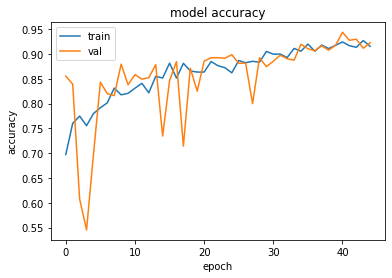

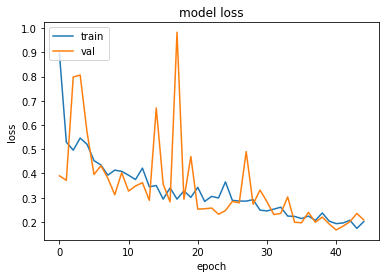

In [82]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The validation loss is somewhat volatile however becomes more consistent towards the final epochs, displaying only a small gap from the training loss. This indicates that the final model is a good fit.

In [104]:
## Create a confusion matrix. Recall [1,0] is a COVID representation, so now 0 is a representation of COVID since their
## predicted y is larger on the LHS

y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

conf = sklearn.metrics.confusion_matrix(y_true, y_pred)
print(conf)

tp, tn, fp, fn = conf[0,0], conf[1,1], conf[1,0], conf[0,1]

[[245   6]
 [ 32 214]]


In [108]:
print('f1 score =  %.3f'%(2*tp/(2*tp+fp+fn)))
print('Precision =  %.3f'%(tp/(tp+fp)))
print('Test accuracy =  %.3f'%((tp+tn)/(tp+tn+fp+fn)))
print('Specificity =  %.3f'%(tn/(tn+fp)))
print('Sensitivity =  %.3f'%(tp/(tp+fn)))

f1 score =  0.928
Precision =  0.884
Test accuracy =  0.924
Specificity =  0.870
Sensitivity =  0.976
